### Import Libraries

In [7]:
from datetime import datetime
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

import statsmodels.api as sm
import warnings
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

### Load Dataset

In [8]:
df = pd.read_csv("../../csv/Beras.csv")
df

,Tanggal,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Harga Beras Penggilingan,Produksi Beras,Harga Beras,UMP,BBM Solar,Tingkat Konsumsi
0,2021-03-15,10,4000,4150,5050,9465,14419,11200,4960,9600,17161
1,2021-03-16,10,3850,4100,4740,9360,14419,11200,4960,9600,17161
2,2021-03-17,10,4160,4230,4950,9400,14419,11200,4960,9600,17161
3,2021-03-18,10,4120,4190,4730,9340,14419,11200,4960,9600,17161
4,2021-03-19,10,4190,4290,4990,9410,14419,11200,4960,9600,17161
...,...,...,...,...,...,...,...,...,...,...,...
673,2023-12-21,30,6770,6850,7980,13100,14391,14000,5444,6800,17598
674,2023-12-22,30,6600,6760,8050,13095,14391,14000,5444,6800,17598
675,2023-12-27,30,6620,6760,8030,13120,14391,14000,5444,6800,17598
676,2023-12-28,30,6650,6760,8020,13120,14391,14000,5444,6800,17598


### Preprocessing

In [9]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df['Year'] = df['Tanggal'].dt.year
df['Month'] = df['Tanggal'].dt.month

In [10]:
X = df.drop('Harga Beras', axis=1)
y = df['Harga Beras']

In [11]:
cutoff_index = int(len(df) * 0.8)

# Split the dataset into training and testing sets using the calculated index
X_train = X.iloc[:cutoff_index]
X_test = X.iloc[cutoff_index:]
y_train = y.iloc[:cutoff_index]
y_test = y.iloc[cutoff_index:]

In [12]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

# Assuming X_train and y_train are already defined as DataFrames and appropriately preprocessed

# Convert DataFrame to numpy array
X_train_array = X_train.to_numpy()
X_test_array = X_test.to_numpy()

# Reshape input to be [samples, time steps, features] for LSTM
X_train_reshaped = X_train_array.reshape((X_train_array.shape[0], 1, X_train_array.shape[1]))
X_test_reshaped = X_test_array.reshape((X_test_array.shape[0], 1, X_test_array.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
model.fit(X_train_reshaped, y_train, epochs=100, batch_size=1, verbose=2)

# Make predictions
train_predict = model.predict(X_train_reshaped)
test_predict = model.predict(X_test_reshaped)

# Calculate and print performance metrics
train_mae = mean_absolute_error(y_train, train_predict)
test_mse = mean_squared_error(y_test, test_predict)
test_rmse = sqrt(test_mse)
print('Train Mae:', train_mse)
print('Test MSE:', test_mse)
print('Test RMSE:', test_rmse)

2024-05-12 14:57:09.392081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-12 14:57:09.393726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-12 14:57:09.394399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type Timestamp).

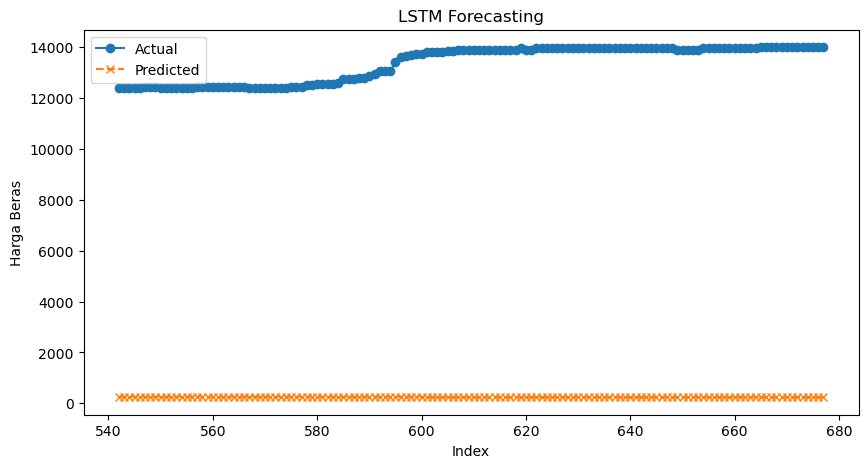

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(X_test.index, y_test, label='Actual', marker='o')
plt.plot(X_test.index, test_predict, label='Predicted', linestyle='--', marker='x')
plt.xlabel('Index')
plt.ylabel('Harga Beras')
plt.title('LSTM Forecasting')
plt.legend()
plt.show()

In [ ]:
look_back = 11  # set look_back to the number of features in your training set
future_predictions = []
current_batch = X_train.iloc[-1].values.reshape((1, 1, look_back))
for i in range(90):
    current_pred = model.predict(current_batch)[0]
    future_predictions.append(current_pred)
    current_pred = current_pred.reshape((1, 1, look_back))  # reshape current_pred to a 3-dimensional array
    current_batch = np.append(current_batch[:,1:,:], current_pred, axis=1).reshape(1, 1, look_back)

1/1 [==============================] - 0s 10ms/step


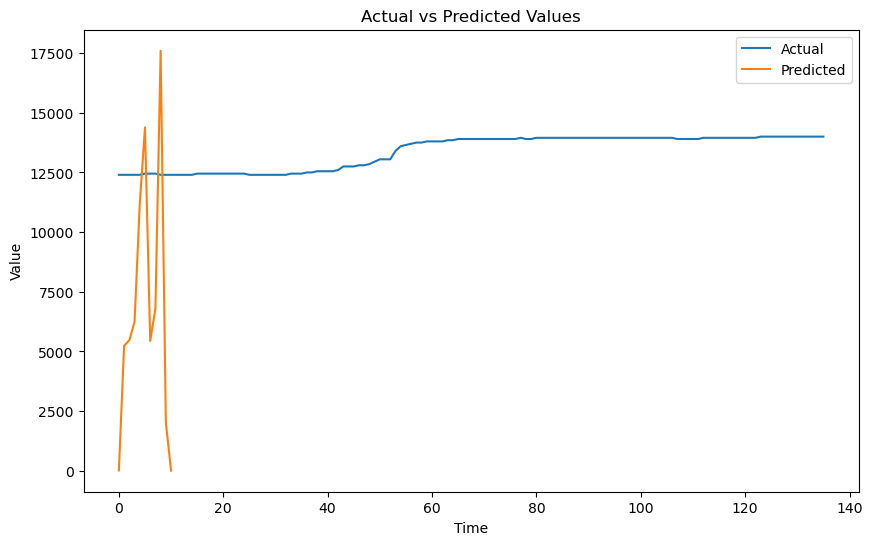

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'actual_values' is a list of your actual values for the next 90 days
actual_values = y_test.tolist()

# 'future_predictions' is your list of predicted values
future_predictions = np.array(future_predictions).flatten()

plt.figure(figsize=(10,6))
plt.plot(actual_values, label='Actual')
plt.plot(future_predictions, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()